In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
import scipy.interpolate as inter
import plotly.express as px
from sklearn import preprocessing as skprep
import numba
import timeit
import math
import itertools
from pprint import pprint
from mnk import MNK

In [86]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

In [87]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    dfn = x.size-1 #define degrees of freedom numerator
    dfd = y.size-1 #define degrees of freedom denominator
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic
    return f, p

In [88]:
# df = pd.read_csv("DataSet5_1.csv", sep=',', header=None)
# df = df.dropna()
# df = df.reset_index(drop=True)

# df[7] = norm(df[0].values.astype("float64"))
# # df["Year"] = df["Year"].astype("int")
# # df["Total confirmed cases of COVID-19"] = df["Total confirmed cases of COVID-19"].astype("int")
# # df = df.drop(columns=["Entity", "Code", "Continent", "Year"])
# df.info()

In [89]:
df = pd.read_csv("DataSet5_1.csv", sep=',', header=None)
df = df.dropna()
df[0] = pd.to_datetime(df[0], dayfirst=True)
df[0] = norm(df[0].values.astype("float64"))
df = df.drop_duplicates()
df = df.reset_index(drop=True)

df.columns = ['Дата мониторинга', "Кура охлажденная и мороженая. руб./кг",
           "Молоко цельное питьевое 2.5-3.2% жирности. руб./л", "Мука пшеничная в/с. руб./кг",
           "Хлеб и булочные изделия из пшеничной муки 1 и 2 с.. руб./кг", "Яйцо куриное. руб./дес.",
           "Картофель. Руб./к"]

predict_column = "Дата мониторинга"

columns = list(df.columns)
columns.remove(predict_column)
columns = [predict_column] + columns
columns = pd.Index(columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Дата мониторинга                                             63 non-null     float64
 1   Кура охлажденная и мороженая. руб./кг                        63 non-null     float64
 2   Молоко цельное питьевое 2.5-3.2% жирности. руб./л            63 non-null     float64
 3   Мука пшеничная в/с. руб./кг                                  63 non-null     float64
 4   Хлеб и булочные изделия из пшеничной муки 1 и 2 с.. руб./кг  63 non-null     float64
 5   Яйцо куриное. руб./дес.                                      63 non-null     float64
 6   Картофель. Руб./к                                            63 non-null     float64
dtypes: float64(7)
memory usage: 3.6 KB


In [90]:
df

,Дата мониторинга,Кура охлажденная и мороженая. руб./кг,Молоко цельное питьевое 2.5-3.2% жирности. руб./л,Мука пшеничная в/с. руб./кг,Хлеб и булочные изделия из пшеничной муки 1 и 2 с.. руб./кг,Яйцо куриное. руб./дес.,Картофель. Руб./к
0,0.000000,134.50,40.15,31.48,39.67,48.79,16.15
1,0.002688,136.97,40.80,32.02,40.37,48.26,18.90
2,0.017742,139.06,41.07,33.24,40.56,50.98,22.26
3,0.033333,139.17,41.11,34.94,42.28,56.48,24.63
4,0.051613,141.67,42.12,36.14,42.60,58.92,28.69
...,...,...,...,...,...,...,...
58,0.932258,156.35,47.88,42.19,54.25,59.16,39.11
59,0.951075,157.19,47.94,42.32,55.13,59.26,23.32
60,0.966129,157.27,47.61,41.85,55.21,59.38,16.35
61,0.985484,156.58,49.74,41.61,55.38,61.23,15.42


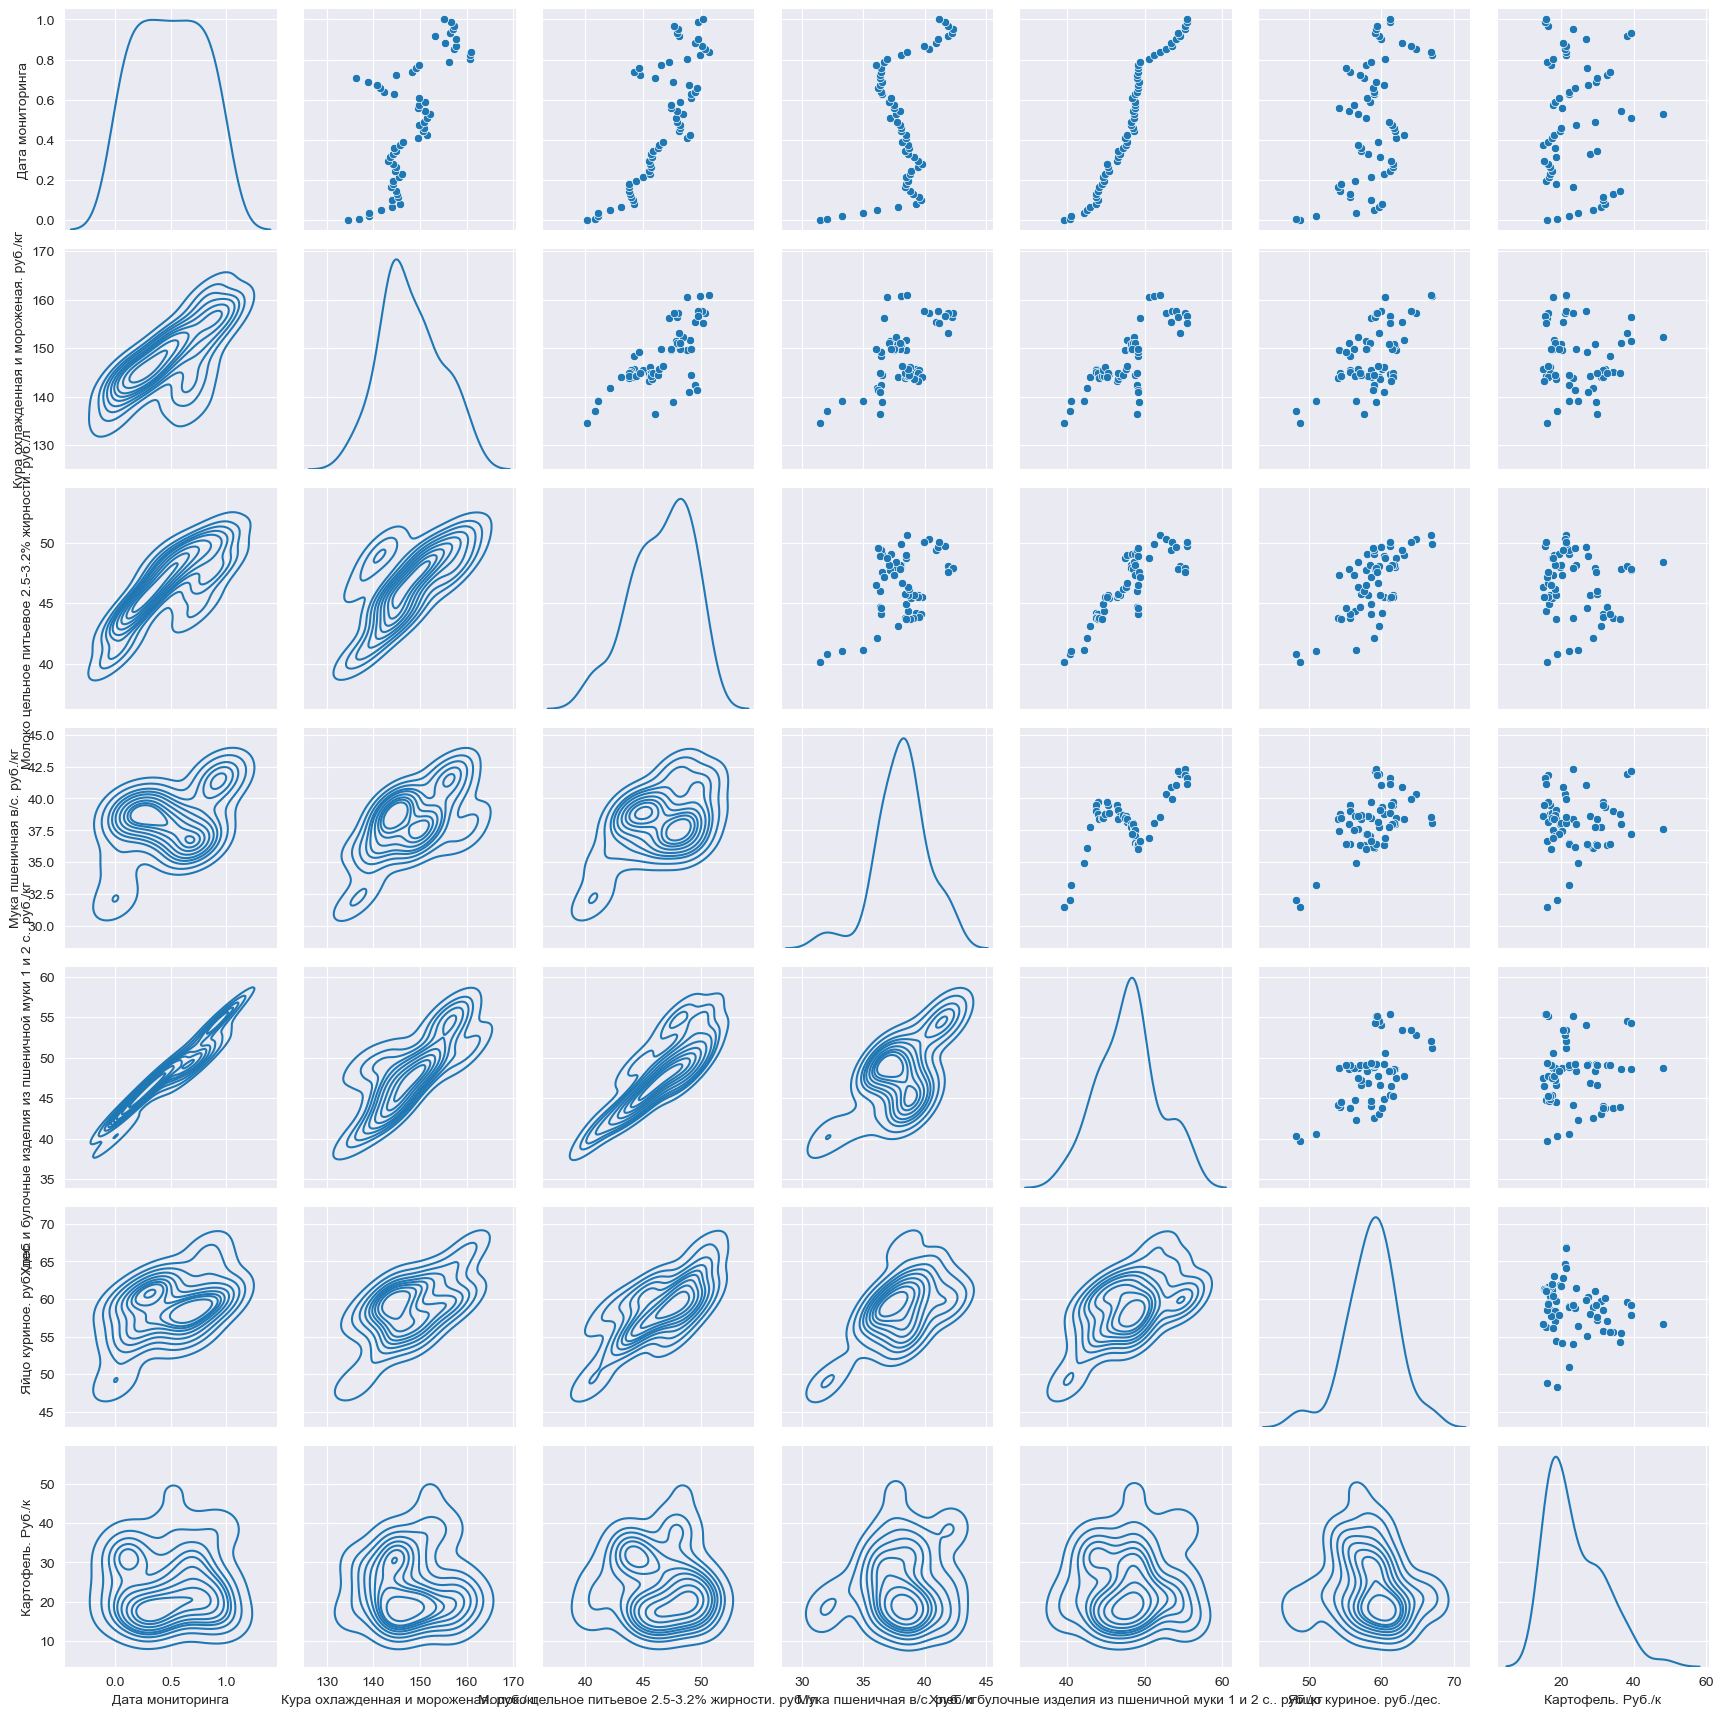

In [91]:
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
plt.show()

# Sample

In [92]:
sample = df.sample(
    # 5
    int(len(df) * 0.3)
)
sample = sample.drop_duplicates(subset=[predict_column])
indexes = df.index.delete(df.index.isin(sample.index))
sample = sample.sort_values(by=predict_column)
sample = sample.reset_index(drop=True)
X = sample.loc[0:len(sample), df.columns[~df.columns.isin([predict_column])]].to_numpy()
y = sample.loc[0:len(sample), [predict_column]].to_numpy()

In [93]:
sample

,Дата мониторинга,Кура охлажденная и мороженая. руб./кг,Молоко цельное питьевое 2.5-3.2% жирности. руб./л,Мука пшеничная в/с. руб./кг,Хлеб и булочные изделия из пшеничной муки 1 и 2 с.. руб./кг,Яйцо куриное. руб./дес.,Картофель. Руб./к
0,0.081720,145.70,44.20,39.30,43.80,60.10,32.20
1,0.164516,143.89,43.78,38.37,44.19,54.06,23.31
2,0.179570,144.16,43.73,38.48,44.55,54.37,18.53
3,0.262366,144.87,45.66,39.47,45.31,61.61,16.84
4,0.390323,146.38,46.72,38.12,47.78,59.54,16.37
5,0.443011,150.57,48.04,38.02,48.61,61.88,19.59
6,0.525806,152.22,48.45,37.61,48.67,56.73,48.15
7,0.559677,149.65,47.39,37.47,48.76,54.17,20.27
8,0.574731,149.89,47.34,37.50,48.71,56.22,17.67
9,0.627957,144.42,49.07,36.53,48.79,59.02,22.18


# МНК

In [94]:
funcs = [
    lambda x: x[0] ** 0,
    lambda x: x[0],
    lambda x: x[0] ** 2,
    lambda x: x[1],
    lambda x: x[1] ** 2,
    lambda x: x[2],
    lambda x: x[2] ** 2,
    lambda x: x[3],
    lambda x: x[3] ** 2,
    lambda x: x[4],
    lambda x: x[4] ** 2,
    lambda x: x[5],
    lambda x: x[5] ** 2,
    # lambda x: x[6],
    # lambda x: x[6] ** 2,
]
# funcs[1](df.loc[:, 1:6].to_numpy().T), funcs[16](df.loc[:, 1:6].to_numpy().T)
mnk = MNK(sample.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T, sample[predict_column].values, funcs)
# mnk = MNK(df.loc[:, 1:6].to_numpy().T, df[7].values, funcs)
mnk.c

array([ 8.26810185e+01, -2.99985625e-01,  1.04162542e-03, -4.26467666e-01,
        4.46859175e-03, -3.25139270e+00,  4.20071035e-02,  7.83909126e-01,
       -7.56066757e-03, -2.66305745e-01,  2.27203577e-03, -9.76396308e-04,
        6.38691379e-06])

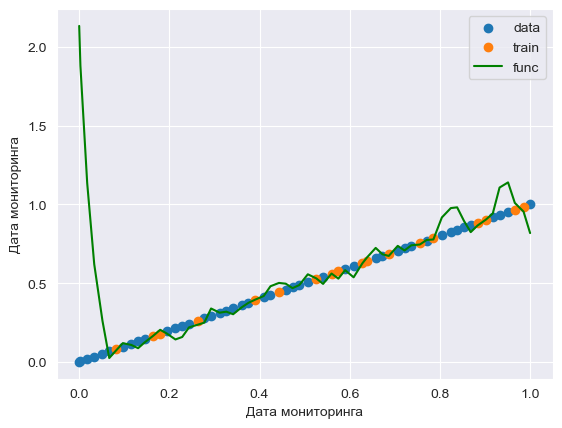

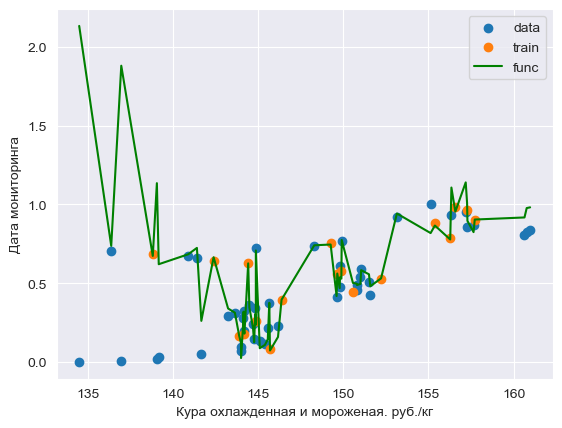

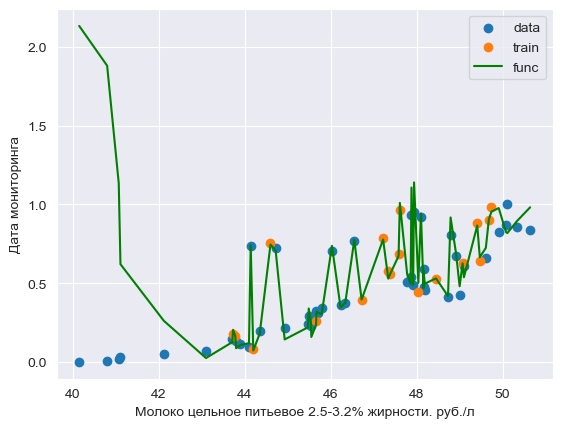

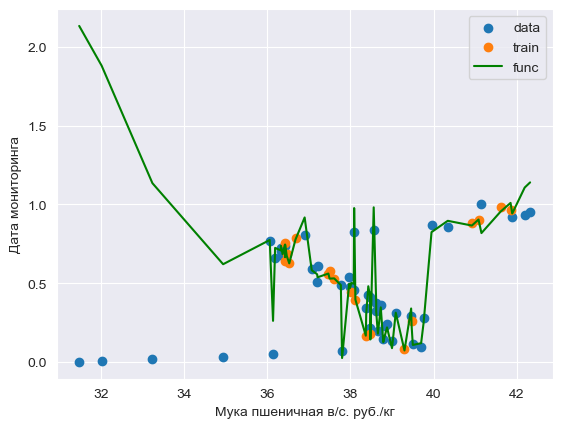

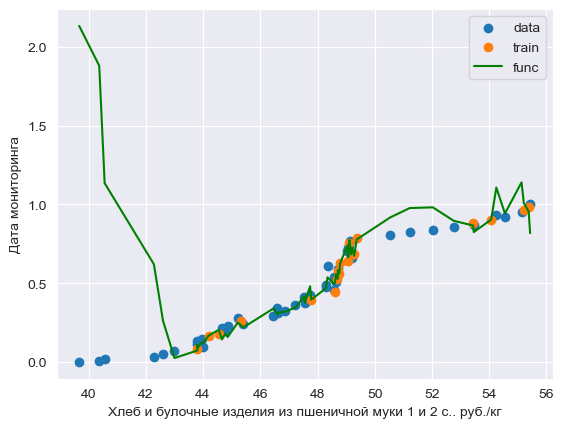

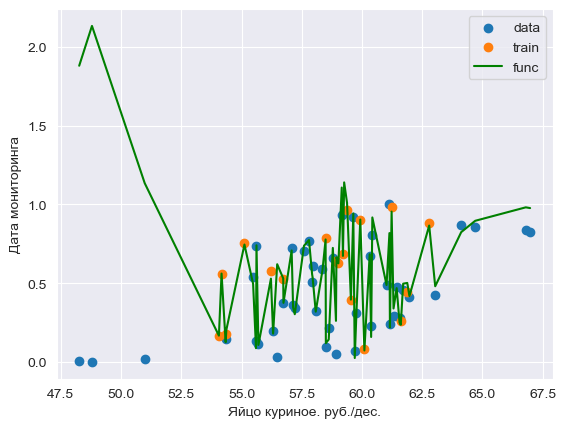

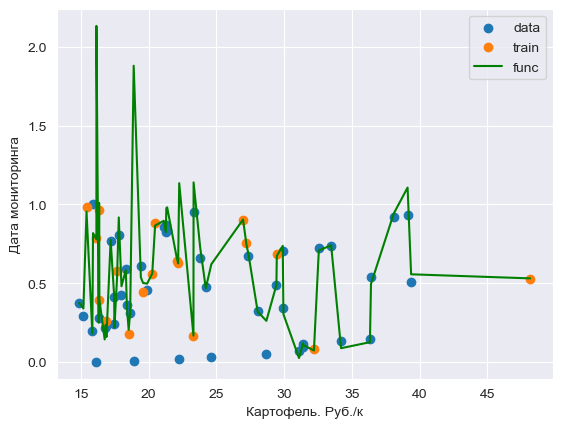

In [95]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], mnk(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T), label='func', color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T)
exp_data = exp_data.reshape(len(exp_data))

<AxesSubplot:>

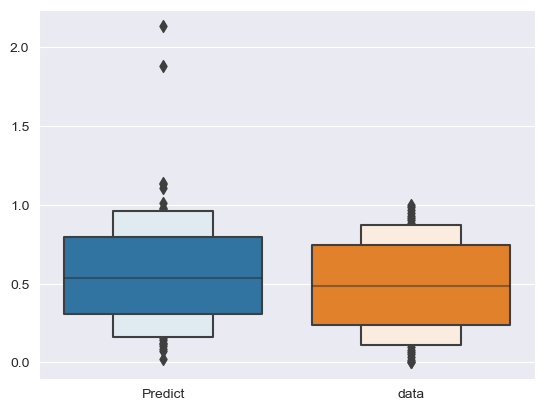

In [96]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

In [97]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=1.6072637533644105, pvalue=0.11053994436891193)
F-test   stat = 1.7428860630805096, pvalue = 0.015206901723713973
X2       stat = 5.393352243489864, pvalue = 1.0


# kNN

In [98]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

KNeighborsRegressor()

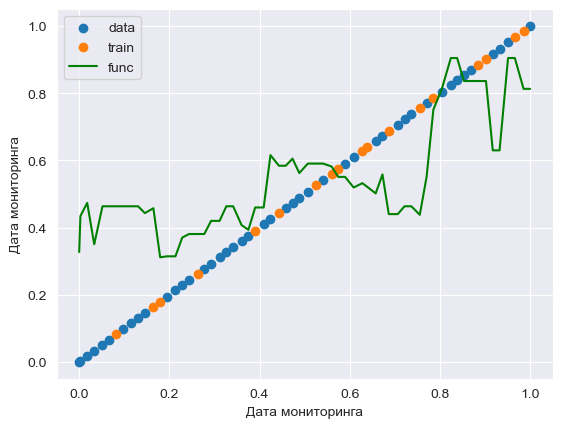

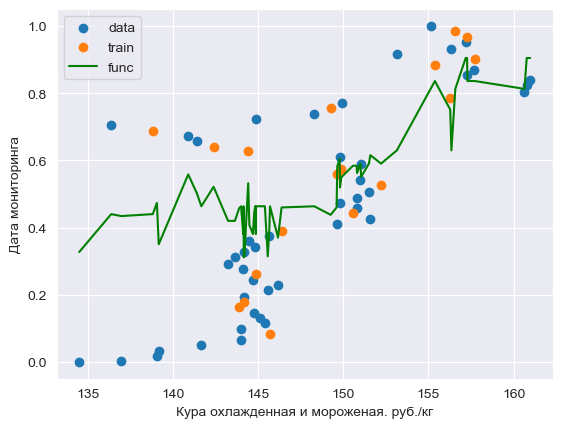

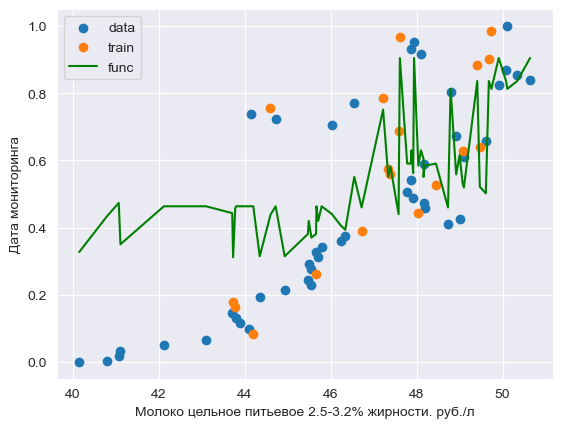

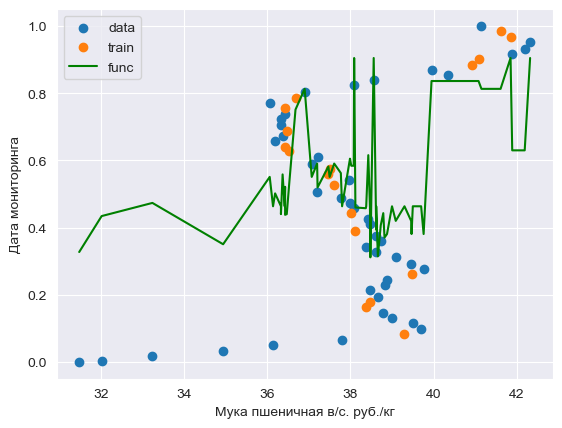

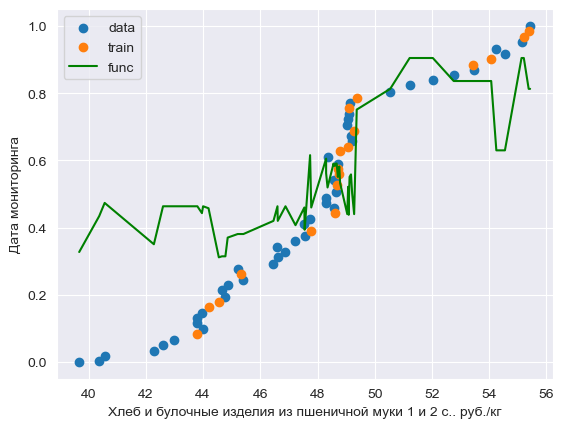

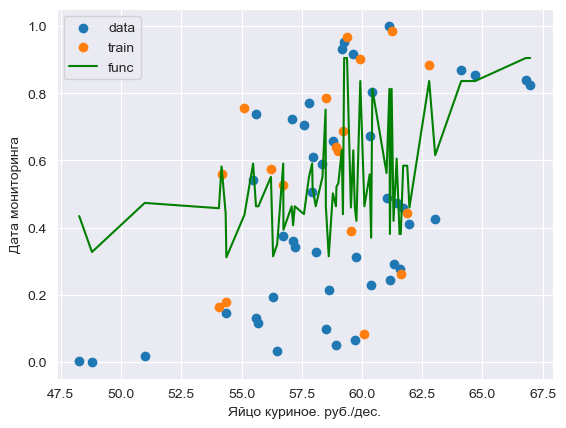

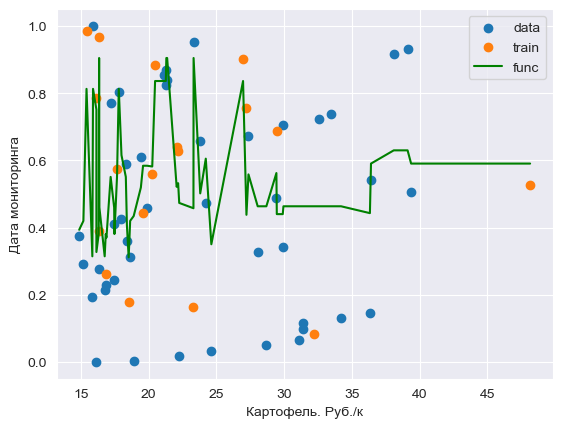

In [99]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], neigh.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = neigh.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

<AxesSubplot:>

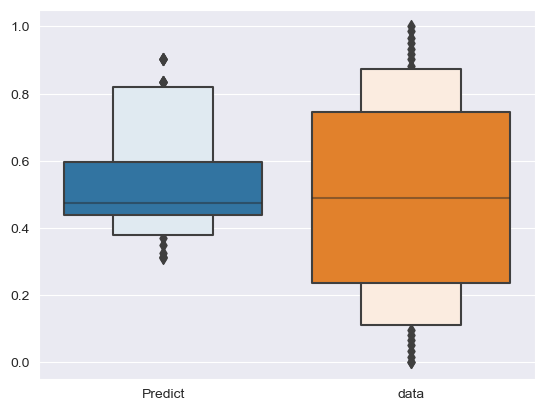

In [100]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

In [101]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=1.2656162603842716, pvalue=0.20802336851438172)
F-test   stat = 0.30995657841830604, pvalue = 0.9999961148738239
X2       stat = 4.042195561175829, pvalue = 1.0


# Lasso

In [102]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.5)
lasso.fit(X, y)

Lasso(alpha=0.5)

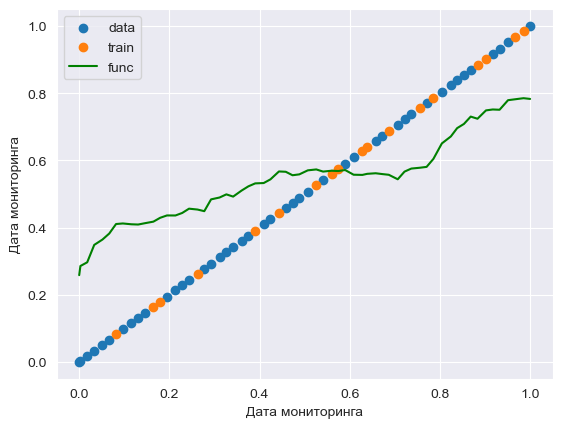

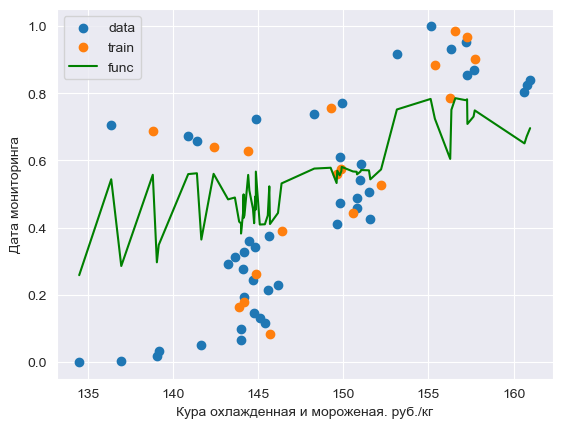

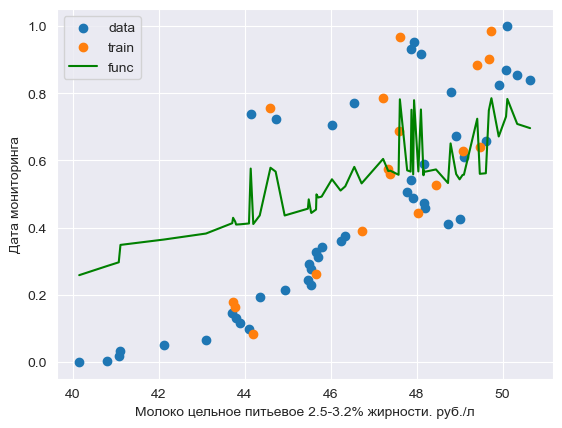

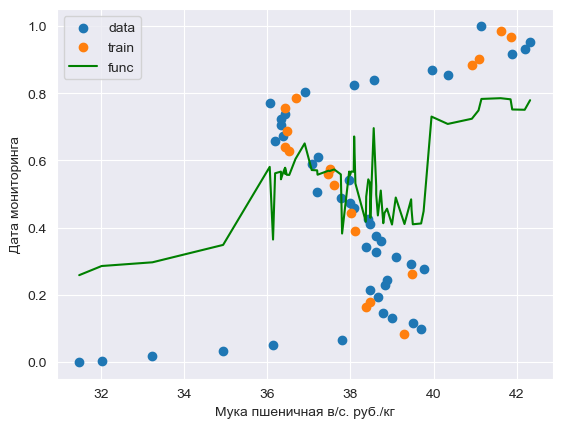

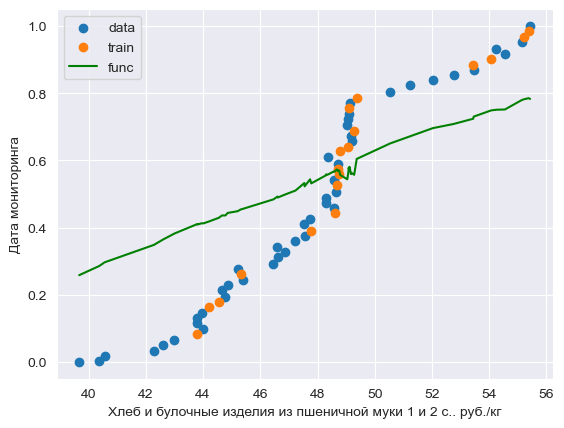

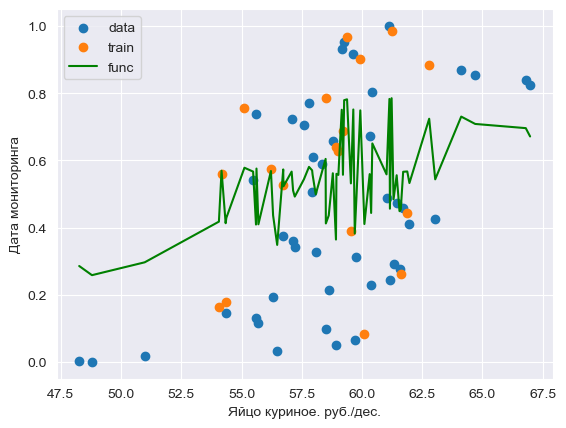

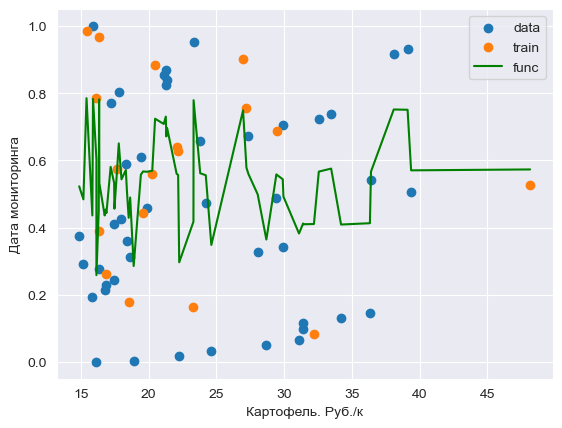

In [103]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], lasso.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = lasso.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())

<AxesSubplot:>

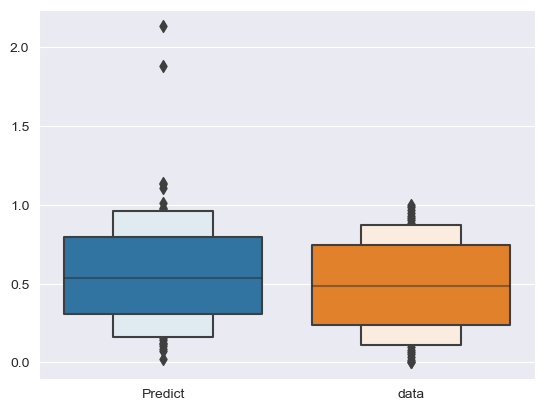

In [104]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

In [105]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=1.2136726482674287, pvalue=0.2271794058035139)
F-test   stat = 0.18050214838753634, pvalue = 0.9999999998997385
X2       stat = 3.5089605198453557, pvalue = 1.0


# Ridge

In [106]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5)
ridge.fit(X, y)

Ridge(alpha=0.5)

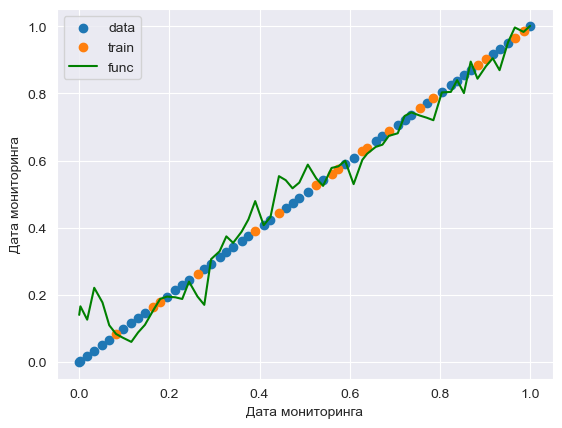

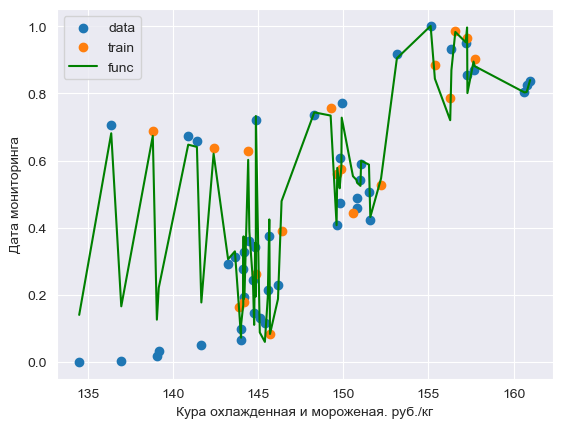

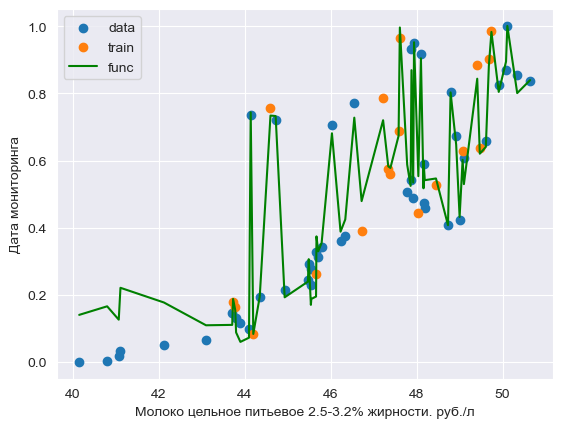

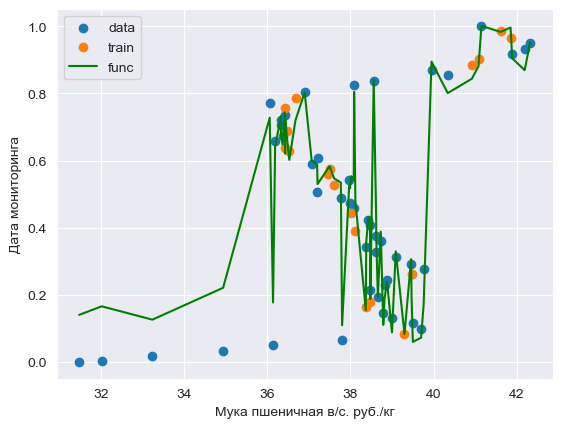

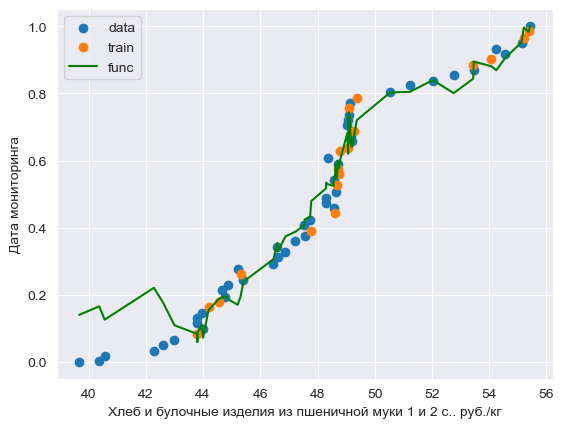

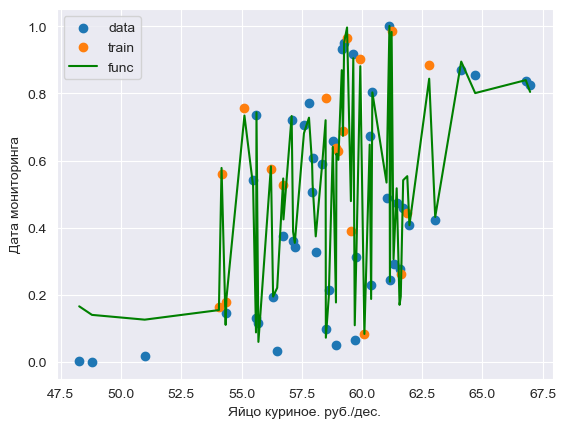

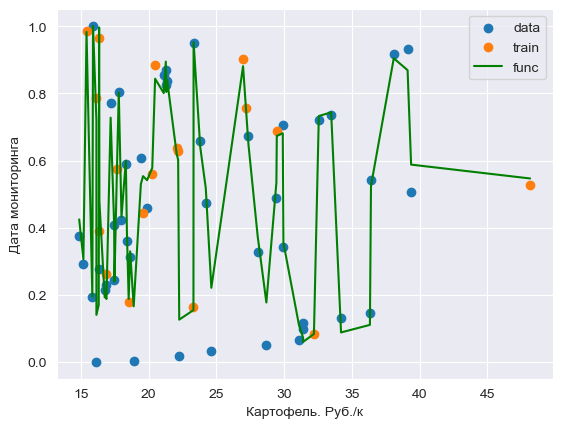

In [107]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], ridge.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = ridge.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

<AxesSubplot:>

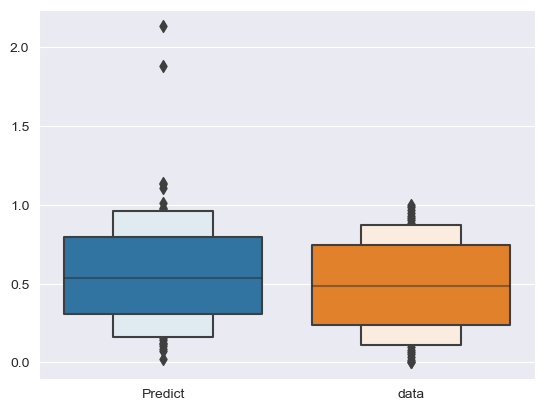

In [108]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

In [109]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=0.17247195717053518, pvalue=0.8633476935548468)
F-test   stat = 0.8906441367366613, pvalue = 0.6750800932434153
X2       stat = 0.7338857553274601, pvalue = 1.0
